<a href="https://colab.research.google.com/github/rmattson1008/ml_for_grady_workshops/blob/draft/SEE_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Python
Main goal: analyze some tweets!   
Sub goal: get comfortable with common ML tools for python

<!-- 
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment?text=I+like+you.+I+love+you -->

https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=Covid+cases+are+increasing+fast%21

### Set up the environment
Colab is hosting a workspace for us, and we need to fill it with python tools. Some of them are already added to the workspace, ready to import into the notebook, but some need to be installed first. 

Colab is wonderfult because you can run on google's servers, either gpu (for fast computation) or cpu (like your local computer). The only issue is since it's free, it occasionally kicks you off the gpu to make room for paying customers :( 

You can choose to work on google hosted servers or your own computer by clicking the dropdown where it says "RAM" in the top right corner.

In [ ]:
# '!' means these commands will execute on the command line, making changes outside of the notebook. 
# !pip install -U -q PyDrive
# !pip install -q xlrd
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 29.2 MB/s 
     |████████████████████████████████| 182 kB 67.8 MB/s 
     |████████████████████████████████| 7.6 MB 40.6 MB/s 


In [ ]:
# importing miscelaneaous packages 
import numpy as np # fast manipulation of multidimensional arrays

from tqdm.notebook import tqdm as progress_bar # a little vizualization of how fast a loop is running
from scipy.special import softmax
import csv
import urllib.request
from datetime import datetime
from matplotlib.dates import date2num

# more packages, tools for getting to google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

### Load Data
We will load some tweets from a shared google drive file, which will require us to sign into our google drive accounts. 
[backup link to shared file](https://docs.google.com/spreadsheets/d/1t_a3Xotu8IsTaQ1b14FYiNf7xGJeviN2/edit?usp=sharing&ouid=104582923093703409002&rtpof=true&sd=true)

<!-- # id = '1prY6_BgwYrUHCSJ0DYAB4KA7HcjTdDtU' -->

*key python package: pandas*

In [ ]:
import pandas as pd # basically the excel of python

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# I got this id from the link to the shared data
id = '1t_a3Xotu8IsTaQ1b14FYiNf7xGJeviN2'

In [ ]:
# this will take a little bit of time
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('twitter_data_full.xlsx')
print("Added file to workspace")

df = pd.read_excel('twitter_data_full.xlsx')
print("Loaded file to notebook as a dataframe")

Added file to workspace
Loaded file to notebook as a dataframe


In [ ]:
df.head(5) # lets look at the first five data samples

,Date,Full Text,Url,Sentiment,Emotion,Page Type,Language,Country Code,Continent Code,Continent,...,Mentioned Authors,Twitter Followers,Twitter Following,Twitter Reply Count,Twitter Retweets,Twitter Tweets,Twitter Verified,Reach (new),Twitter Likes,cleaned_text
0,2022-10-01 23:40:00.000,"In Colorado Senate race, Michael Bennet still ...",http://twitter.com/Prison_Health/statuses/1576...,negative,NaN,twitter,en,USA,NORTH AMERICA,North America,...,NaN,19711.0,2715.0,0.0,0.0,441744.0,False,7325.0,NaN,"in colorado senate race, michael bennet still ..."
1,2022-10-01 23:27:28.000,COMING UP on @WRAL at 7:30pm: We sit down with...,http://twitter.com/BryanRAnderson/statuses/157...,neutral,NaN,twitter,en,USA,NORTH AMERICA,North America,...,"@wral, @bohines, @wileynickel",3832.0,1103.0,2.0,4.0,17642.0,True,13263.0,NaN,coming up on at 7:30pm: we sit down with and...
2,2022-10-01 23:16:38.000,Summaries of high-profile Supreme Court cases:...,http://twitter.com/January20th49/statuses/1576...,neutral,Fear,twitter,en,USA,NORTH AMERICA,North America,...,NaN,39.0,300.0,0.0,1.0,5523.0,False,0.0,NaN,summaries of high-profile supreme court cases:...
3,2022-10-01 23:05:12.000,Abortion Icon Emma Bonino Trounced in Italian ...,http://twitter.com/UsBurning/statuses/15763475...,neutral,NaN,twitter,en,USA,NORTH AMERICA,North America,...,NaN,360.0,34.0,0.0,0.0,23157.0,False,0.0,NaN,abortion icon emma bonino trounced in italian ...
4,2022-10-01 22:02:12.000,💥38 DAYS UNTIL #ELECTIONDAY MIDTERMS💥 WHAT R U...,http://twitter.com/LeviFetterman/statuses/1576...,neutral,NaN,twitter,en,USA,NORTH AMERICA,North America,...,NaN,33774.0,1702.0,1.0,10.0,49930.0,False,16039.0,NaN,💥38 days until midterms💥 what r u doing for d...


### Clean Data
Gameplan: make functions that cleans one tweet. Then apply this function to every tweet in our dataframe.

[using regex to remove hashtags](https://catriscode.com/2021/03/02/extracting-or-removing-mentions-and-hashtags-in-tweets-using-python/)   
[regex cheatsheet](https://www.interviewbit.com/regex-cheat-sheet/)


*key python package: regex*

In [ ]:
import re # search through and clean text

In [ ]:
def clean(tweet):
  # remove mentions
  # remove hashtags
  tweet = tweet.lower()

  tweet = re.sub("@[A-Za-z0-9_]+", "", tweet)
  tweet = re.sub("#[A-Za-z0-9_]+", "", tweet)
  temp = re.sub(r"http\S+", "", temp)

  return tweet

In [ ]:
df['cleaned_text'] = df['Full Text'].apply(clean)

### Embed Tweets
We will load up a pretrained model to our workspace. This model will first tokenize tweets, then map tweets to an embedding space where similar words are near to each other. Then the model will classify each tweet into "positive", "negative", or "neutral" data. 

This model was trained on hand-labeled tweets until it reach a high score on the training task, so we can trust it to be pretty good as long as we only use it on tweet-like data.

*key python package: transformers by Hugging Face*   
[Hugging Face model repository](https://huggingface.co/models)

[our model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=Covid+cases+are+increasing+fast%21)

[how large language models work (specifically chapter 2 but all chapters are good)](https://www.pinecone.io/learn/sentence-embeddings/)


In [ ]:
# huggingface's tools for pretrained language models
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest" 
# MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment" # for multilingual embedding

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# you can choose from many tokenizing options as well
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

labels = ["negative", "neutral", "positive"]

#### Test a few sample sentences

Sentiment analysis has its limits. When it fails, it fails silently.

In [ ]:
# run this cell don't worry about it
def print_scores(text):
  """a function to print out sentiment scores for one text sample in a pretty way"""
  print(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")
  print()
  return 

In [ ]:
# let's test a few sentences
print_scores("I ❤️ u")
print_scores("I love you")
print_scores("I love you but")

I ❤️ u
1) positive 0.935
2) neutral 0.0585
3) negative 0.0064

I love you
1) positive 0.8595
2) neutral 0.1224
3) negative 0.0181

I love you but
1) positive 0.4558
2) neutral 0.4319
3) negative 0.1123



In [ ]:
# what about hard sentiment questions?
# constrast
print_scores("The weather was terrible, but the hike was amazing!")
# sarcasm
print_scores("I’m so happy the plane is delayed.")

The weather was terrible, but the hike was amazing!
1) positive 0.7476
2) negative 0.1333
3) neutral 0.119

I’m so happy the plane is delayed.
1) positive 0.8312
2) neutral 0.1096
3) negative 0.0592



In [ ]:
# try your own sentence
print_scores("")


1) positive 0.4013
2) neutral 0.3731
3) negative 0.2256



#### Apply roberta to tweets the slow way:
Getting scores one at a time by traversing through a dataframe sequentially

In [ ]:
def get_score(tweet):
  "get the sentiment scores for a tweet"
  encoded_input = tokenizer(tweet, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  return scores

In [ ]:
# honestly way too slow - don't bother to run this code on all the tweets
model = model.to('cpu')
sentiments = df[:50].apply(lambda row: get_score(row.cleaned_text), axis='columns', result_type='expand').to_numpy()

In [ ]:
sentiment_df =  pd.DataFrame(sentiments, columns=labels)
sentiment_df['Full Text'] = df['Full Text'][:50]
sentiment_df['cleaned_text'] = df['cleaned_text'][:50]
sentiment_df.head(10)

,negative,neutral,positive,Full Text,cleaned_text
0,0.030664,0.899153,0.070183,"In Colorado Senate race, Michael Bennet still ...","in colorado senate race, michael bennet still ..."
1,0.011117,0.952506,0.036376,COMING UP on @WRAL at 7:30pm: We sit down with...,coming up on at 7:30pm: we sit down with and...
2,0.022494,0.936890,0.040616,Summaries of high-profile Supreme Court cases:...,summaries of high-profile supreme court cases:...
3,0.300519,0.663301,0.036179,Abortion Icon Emma Bonino Trounced in Italian ...,abortion icon emma bonino trounced in italian ...
4,0.024535,0.679589,0.295876,💥38 DAYS UNTIL #ELECTIONDAY MIDTERMS💥 WHAT R U...,💥38 days until midterms💥 what r u doing for d...
5,0.831015,0.156397,0.012589,@juliaioffe Is it worse to have a POTUS who gl...,is it worse to have a potus who glibly says h...
6,0.320765,0.584097,0.095138,Everyone eligible to vote should be allowed to...,everyone eligible to vote should be allowed to...
7,0.157585,0.822115,0.020301,"Abbott and O’Rourke clash on immigration, guns...","abbott and o’rourke clash on immigration, guns..."
8,0.692373,0.290198,0.017430,Majority of Americans support sending illegal ...,majority of americans support sending illegal ...
9,0.543155,0.445710,0.011134,Barnstable County Sheriff Election And Immigra...,barnstable county sheriff election and immigra...


#### Apply roberta to tweets the fast way:
Group our tweets into batches and get many scores at a time

If we put out model on "CUDA" the notebook will process many tweets in at the same time

*relevant python package: pytorch*

In [ ]:
# deep learning toolkit
from torch.utils.data import DataLoader
from torch.nn import Softmax
import torch

In [ ]:
CUDA = torch.cuda.is_available()

print("Using gpu:", CUDA)

if CUDA:
  model = model.to('cuda')
else:
  model = model.to('cpu')

Using gpu: True


In [ ]:
soft = Softmax()
def encode(text, cuda=True):
  """ Takes in cleaned tweets and outputs sentiment scores for each"""
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    embeddings = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    embeddings = output[0].detach().numpy()

  return embeddings

In [ ]:
# making some pytorch variables to assist us
batch_size = 32
dl = DataLoader(df['cleaned_text'], batch_size=batch_size)
print("Number of Batches", len(dl))

Number of Batches 596


In [ ]:
# lets run it! It should take about a minute or so

sentiment_df = pd.DataFrame(columns=labels)
for batch in progress_bar(dl):
  text = batch
  embeddings = encode(text, cuda=CUDA)
  embed_df = pd.DataFrame(embeddings, columns=labels)

  # append new embeddings to current dataframe
  sentiment_df = pd.concat((sentiment_df, embed_df), axis=0, ignore_index=True)
  
# convert embeddings to a probability distribution
sentiment_df = sentiment_df.apply(softmax, axis=1) 

  0%|          | 0/596 [00:00<?, ?it/s]

In [ ]:
def get_class_one_hot(row):
  max_idx = np.argmax(row)
  one_hot = [0,0,0]
  one_hot[max_idx] = 1
  return one_hot

class_df = sentiment_df.apply(lambda row: get_class_one_hot(row), axis=1, result_type='expand')
class_df.columns = labels

In [ ]:
# Transform scores to labels
def get_class(row):
  max_idx = np.argmax(row)
  return labels[max_idx]


,negative,neutral,positive,predicted_class
0,0,1,0,neutral
1,0,1,0,neutral
2,0,1,0,neutral
3,0,1,0,neutral
4,0,1,0,neutral
...,...,...,...,...
19052,1,0,0,negative
19053,0,1,0,neutral
19054,0,1,0,neutral
19055,1,0,0,negative


In [ ]:

class_df["predicted_class"] = sentiment_df.apply(get_class, axis=1)
class_df['text'] = df['Full Text']
class_df['cleaned_text'] = df['cleaned_text']
class_df['date'] = df['Date'].apply(lambda x: x.split()[0])
class_df['gender'] = df['Gender']
class_df

,negative,neutral,positive,predicted_class,text,cleaned_text,date,gender
0,0,1,0,neutral,"In Colorado Senate race, Michael Bennet still ...","In Colorado Senate race, Michael Bennet still ...",2022-10-01,unknown
1,0,1,0,neutral,COMING UP on @WRAL at 7:30pm: We sit down with...,COMING UP on at 7:30pm: We sit down with and...,2022-10-01,male
2,0,1,0,neutral,Summaries of high-profile Supreme Court cases:...,Summaries of high-profile Supreme Court cases:...,2022-10-01,male
3,0,1,0,neutral,Abortion Icon Emma Bonino Trounced in Italian ...,Abortion Icon Emma Bonino Trounced in Italian ...,2022-10-01,unknown
4,0,1,0,neutral,💥38 DAYS UNTIL #ELECTIONDAY MIDTERMS💥 WHAT R U...,💥38 DAYS UNTIL MIDTERMS💥 WHAT R U DOING FOR D...,2022-10-01,male
...,...,...,...,...,...,...,...,...
19052,1,0,0,negative,Senator has been blocking immigration reforms ...,Senator has been blocking immigration reforms ...,2022-11-06,unknown
19053,0,1,0,neutral,Weekend Update: Tammy the Trucker on Gas Price...,Weekend Update: Tammy the Trucker on Gas Price...,2022-11-06,female
19054,0,1,0,neutral,"Letters to the Editor — Plano, voting machines...","Letters to the Editor — Plano, voting machines...",2022-11-06,male
19055,1,0,0,negative,I think Trump is the only Republican that coul...,I think Trump is the only Republican that coul...,2022-11-06,unknown


### Analyze tweets

*key python package: matplotlib*

In [ ]:
# vizualize data
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

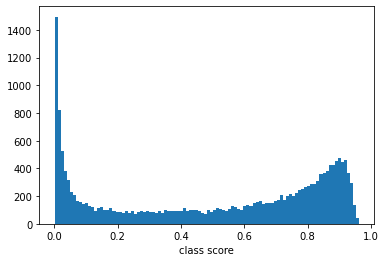

In [ ]:
# don't base real science on confidence scores, but we can still take a look to get a sense of the data
plt.hist(sentiment_df['negative'], bins=100)
plt.xlabel("class score")
plt.show()

Text(0, 0.5, 'Number of Tweets')

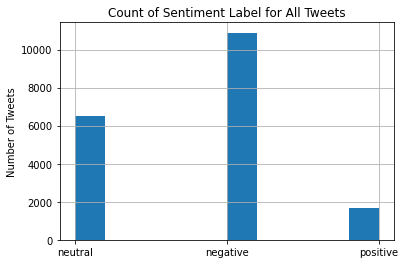

In [ ]:
our_histogram = class_df['predicted_class'].hist()
our_histogram.set_title("Count of Sentiment Label for All Tweets")
our_histogram.set_ylabel("Number of Tweets")

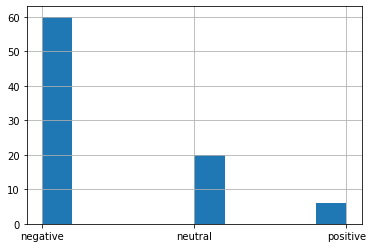

In [ ]:
key_word = df['Full Text'].apply(lambda x: "trump" in str(x))

key_word_df = class_df[key_word]
key_word_df.reset_index()
histogram = key_word_df['predicted_class'].hist()

## Some Funkier Plots

In [ ]:
by_date = class_df.groupby('date', as_index=False)['negative', 'neutral', 'positive'].sum()
by_date['int_date'] = by_date['date'].apply(lambda x: matplotlib.dates.date2num(datetime.strptime(x, '%Y-%m-%d')))
by_date.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,date,negative,neutral,positive,int_date
0,2022-01-01,5,4,1,738156.0
1,2022-01-02,13,9,3,738157.0
2,2022-01-03,19,16,4,738158.0
3,2022-01-04,16,10,7,738159.0
4,2022-01-05,18,11,4,738160.0


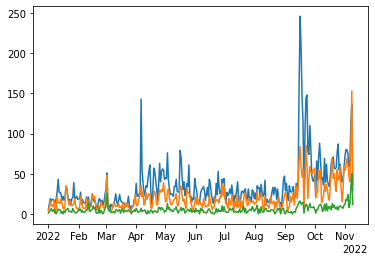

In [ ]:
plt.plot('int_date', 'negative', data=by_date)
plt.plot('int_date', 'neutral', data=by_date)
plt.plot('int_date', 'positive', data=by_date)

ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.show()

In [ ]:
class_df['state'] = df['Region Code'].apply(lambda x: str(x)[-2:])
by_state = class_df.groupby('state', as_index=False)['negative', 'neutral', 'positive'].mean()
by_state.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,state,negative,neutral,positive
0,AK,0.611111,0.333333,0.055556
1,AL,0.698925,0.215054,0.086022
2,AR,0.603774,0.320755,0.075472
3,AZ,0.588430,0.317355,0.094215
4,CA,0.586500,0.306296,0.107204


In [ ]:
fig = px.choropleth(by_state,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='negative',
                    color_continuous_scale="Viridis_r", 
                    # range_color=(0,1)
                    )
fig.show()

# Save your work

In [ ]:
# let's save it to the workspace
# this will only save to worksplace and then you have to download it to your local computer.
sentiment_df.to_excel("roberta_sentiment_scores.xlsx")

Other things you might try that are related

[tag subjectivity of a sentence - a different pipeline](https://spacy.io/universe/project/spacy-textblob)

[label emotions](https://huggingface.co/cardiffnlp/twitter-roberta-base-emotion?text=I+like+you.+I+love+you)

[topic modeling with BERTTopic](https://www.pinecone.io/learn/bertopic/)

